## Time-series Model for crash prediction
### Developed by: bpben
#### Details steps of data processing, feature engineering and model tuning/testing for crash, concern and road data

In [6]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as ss
from glob import glob
from simpledbf import Dbf5

Helpers for tuning/testing models, available [here](https://github.com/bpben/model_helpers) as well

In [57]:
import sklearn.ensemble as ske
import sklearn.linear_model as skl
from sklearn import metrics
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn import cross_validation as cv

class Indata():
    scoring = None
    data = None
    train_x, train_y, test_x, test_y = None, None, None, None
    is_split = 0
    
    #init with pandas DF and target column name, specify scoring observations
    def __init__(self, data, target, scoring=None):
        #If scoring observations, store under scoring attribute
        if scoring is not None:
            self.data = data[~(scoring)]
            self.scoring = data[scoring]
        else:
            self.data = data
        self.target = target
    
    # Split into train/test
    # pct = percent training observations
    # datesort = specify date column for sorting values
    #   If this is not None, split will be non-random (i.e. split on sorted obs)
    def tr_te_split(self, pct, datesort=None):
        if datesort:
            self.data.sort_values(datesort, inplace=True)
            self.data.reset_index(drop=True, inplace=True)
            inds = np.arange(0.0,len(self.data)) / len(self.data) < pct
        else:
            inds = np.random.rand(len(self.data)) < pct
        self.train_x = self.data[inds]
        print 'Train obs:', len(self.train_x)
        self.train_y = self.data[self.target][inds]
        self.test_x = self.data[~inds]
        print 'Test obs:', len(self.test_x)
        self.test_y = self.data[self.target][~inds]
        self.is_split = 1
        
class Tuner():
    """
    Initiates with indata class, will tune series of models according to parameters.  
    Outputs RandomizedGridCV results and parameterized model in dictionary
    """
    
    data = None
    train_x, train_y = None, None
    
    def __init__(self, indata, best_models=None, grid_results=None):
        if indata.is_split == 0:
            raise ValueError('Data is not split, cannot be tested')
        else:
            self.data = indata.data
            self.train_x = indata.train_x
            self.train_y = indata.train_y
            if best_models is None:
                self.best_models = {}
            if grid_results is None:
                self.grid_results = pd.DataFrame()
        
            
    def make_grid(self, model, obs, cvparams, mparams):
        #Makes CV grid
        grid = RandomizedSearchCV(
                    model(),scoring=cvparams['pmetric'], 
                    cv = cv.KFold(obs,cvparams['folds']), 
                    refit=False, n_iter=cvparams['iter'],
                    param_distributions=mparams, verbose=1)
        return(grid)
    
    def run_grid(self, grid, train_x, train_y):
        grid.fit(train_x, train_y)
        results = pd.DataFrame(grid.cv_results_)[['mean_test_score','mean_train_score','params']]
        best = {}
        best['bp'] = grid.best_params_
        best[grid.scoring] = grid.best_score_
        return(best, results)
            
    def tune(self, name, m_name, features, cvparams, mparams):
        if hasattr(ske, m_name):
            model = getattr(ske, m_name)
        elif hasattr(skl, m_name):
            model = getattr(skl, m_name)
        else:
            raise ValueError('Model name is invalid.')
        grid = self.make_grid(model, len(self.train_x), cvparams, mparams)
        best, results = self.run_grid(grid, self.train_x[features], self.train_y)
        results['name'] = name
        results['m_name'] = m_name
        self.grid_results = self.grid_results.append(results)
        best['model'] = model(**best['bp'])
        best['features'] = list(features)
        self.best_models.update({name: best}) 
        
class Tester():
    """
    Initiates with indata class, receives parameterized sklearn models, prints and stores results
    """
    
    def __init__(self, data, rundict=None):
        if data.is_split == 0 :
            raise ValueError('Data is not split, cannot be tested')
        else:
            self.data = data
            if rundict is None:
                self.rundict = {}
            
    #Add tuner object, will populate rundict with names, models, feature
    def init_tuned(self, tuned):
        if tuned.best_models=={}:
            raise ValueError('No tuned models found')
        else:
            self.rundict.update(tuned.best_models)
    
    #Produce predicted class and probabilities
    def predsprobs(self, model, test_x):
        preds = model.predict(test_x)
        probs = model.predict_proba(test_x)[:,1]
        return(preds, probs)
    
    #Produce metrics
    def get_metrics(self, preds, probs, test_y):
        f1_s = metrics.f1_score(test_y, preds)
        brier = metrics.brier_score_loss(test_y, probs)
        return(f1_s, brier)
    
    #Run production, output dictionary
    def make_result(self, model, test_x, test_y):
        preds, probs = self.predsprobs(model, test_x)
        f1_s, brier = self.get_metrics(preds, probs, test_y)
        print "f1_score: ", f1_s
        print "brier_score: ", brier
        result = {}
        #result['preds'] = [int(i) for i in preds]
        #result['probs'] = [float(i) for i in probs]
        result['f1_s'] = f1_s
        result['brier'] = brier
        return(result)

    # Run model - Specify model, with parameters, features
    # Stores it to rundict, can later be output
    # Will overwrite previous run if name is not different
    def run_model(self, name, model, features, cal=True, cal_m='sigmoid'):
        results = {}
        results['features'] = list(features)
        print "Fitting {} model with {} features".format(name, len(features))
        if cal:
            # Need disjoint calibration/training datasets
            # Split 50/50
            rnd_ind = np.random.rand(len(self.data.train_x)) < .5
            train_x = self.data.train_x[features][rnd_ind]
            train_y = self.data.train_y[rnd_ind]
            cal_x = self.data.train_x[features][~rnd_ind]
            cal_y = self.data.train_y[~rnd_ind]
        else:
            train_x = self.data.train_x[features]
            train_y = self.data.train_y

        m_fit = model.fit(train_x, train_y)
        result = self.make_result(
            m_fit,
            self.data.test_x[features],
            self.data.test_y)

        results['raw'] = result
        results['m_fit'] = m_fit
        if cal:
            print "calibrated:"
            m_c = CalibratedClassifierCV(m_fit, method = cal_m, cv='prefit')
            m_fit_c = m_c.fit(cal_x, cal_y)
            result_c = self.make_result(m_fit_c, self.data.test_x[features], self.data.test_y)
            results['calibrated'] = result_c              
            print "\n"
        if name in self.rundict:
            self.rundict[name].update(results)
        else:
            self.rundict.update({name:results})
    
    #Run from tuned set
    def run_tuned(self, name, cal=True, cal_m='sigmoid'):
        self.run_model(name, self.rundict[name]['model'], self.rundict[name]['features'], cal, cal_m)
    
    #Output rundict to csv
    def to_csv(self):
        if self.rundict == {}:
            raise ValueError('No results found')
        else:
            now = pd.to_datetime('today').value
            #Make dataframe, transpose so each row = model
            pd.DataFrame(self.rundict).T.to_csv('results_{}.csv'.format(now))

In [58]:
def read_data(filepath):
    if filepath[-3:]=='dbf':
        db = Dbf5(filepath)
        df = db.to_dataframe()
    else:
        df = pd.read_csv(filepath)
    df.columns = [x.lower() for x in df.columns]
    return(df)

In [59]:
#Function for finding cumsum and then time-shifting forward one
#Creates feature of road's history of crash/concerns
def cumsum_timeshift(group, cols):
    #Fillna for weeks with no data
    r = group[cols].fillna(0)
    r = r.cumsum(skipna=False)
    r = r.shift(1)
    #Fillna for the first observation
    r = r.fillna(0)
    return(r)

### Data processing

In [10]:
#Read in data
crash = read_data('./data/all_crashes.dbf')
concern = read_data('./data/all_concerns.dbf')
incidents = read_data('./data/incidents.csv')
roads = read_data('./data/boston_road_massdot2015.dbf')

In [11]:
#Concern cleaning
#Concern columns have html mixed up in their names
concern['requesttyp'] = concern['requesttyp'].apply(lambda x: re.sub('.*;','',x))

In [12]:
#Concern count by week
con_date = pd.concat([pd.get_dummies(concern['requesttyp']), concern[['near_fid','requestdat']]], axis=1)
con_date = con_date.groupby(['near_fid','requestdat']).sum()
con_date['tot_concerns'] = con_date.apply(sum, axis=1)
con_date.reset_index(inplace=True)

In [13]:
#Drop duplicates in incidents
in_dedup = incidents.groupby('incident').apply(lambda x: x.apply(lambda y: str(y.unique()[0])))
in_dedup.reset_index(drop=True, inplace=True)
#Merge to crash data
cr_in = pd.merge(crash, in_dedup, on='incident', how='left')
cr_in['datetime'] = pd.to_datetime(cr_in['date'])
cr_in['date'] = pd.to_datetime(cr_in.datetime.apply(lambda x: x.date()))

In [14]:
#Limit to crashes in 2016
#Concerns = 2016, crash should = 2016
cr_in = cr_in.set_index('date').loc['2016']
cr_in.reset_index(inplace=True)

In [15]:
#Crash by road index (near_fid)
#near_fid = result of snapping incident lat/longs to road segments
cr_date = pd.concat([pd.get_dummies(cr_in['mode']),cr_in[['near_fid','date']]], axis=1)
cr_date = cr_date.groupby(['near_fid','date']).sum()
cr_date['tot_crash'] = cr_date.apply(sum, axis=1)
#Extra field for shifting time (i.e. crashes as of previous period)
cr_date['tot_crash_shift'] = cr_date['tot_crash']
cr_date.reset_index(inplace=True)

In [17]:
#Merge on fid and date
con_date.requestdat = pd.to_datetime(con_date.requestdat)
cr_date['date'] = pd.to_datetime(cr_date['date'])
cr_con_date = pd.merge(
    con_date, cr_date, how='outer', 
    left_on=['near_fid', 'requestdat'], right_on=['near_fid', 'date'], indicator=True)

In [25]:
#Merge on fid and date
con_date.requestdat = pd.to_datetime(con_date.requestdat)
cr_date['date'] = pd.to_datetime(cr_date['date'])
cr_con_date = pd.merge(
    con_date, cr_date, how='outer', 
    left_on=['near_fid', 'requestdat'], right_on=['near_fid', 'date'], indicator=True)
#Agg by week
#Take whichever date is not missing, find the week number
cr_con_date['week'] = cr_con_date.apply(
    lambda x: x[['date','requestdat']].dropna().max().week, axis=1)
cr_con_date = cr_con_date.groupby(['near_fid','week']).sum()
cr_con_date.reset_index(inplace=True)

In [26]:
#Cumulative sum (for observed weeks rather than all weeks)
cr_con_week = pd.concat([
        cr_con_date[['near_fid','week','tot_crash']],
        cr_con_date.groupby('near_fid').apply(
            lambda x: cumsum_timeshift(
                x, cr_con_date.columns.difference(['near_fid','week','tot_crash']))
        )], axis=1)

In [27]:
#Binary indicator for crash
cr_con_week['crash_binary'] = cr_con_week['tot_crash'].notnull().astype(int)

In [28]:
#Join AADT
full = cr_con_week.merge(roads.reset_index(), left_on='near_fid', right_on='index')

### Model tuning

In [76]:
#Initialize data
#Fill missing 0 (Only affects tot_crash)
df = Indata(full.fillna(0), 'crash_binary')
#Create train/test split
df.tr_te_split(.7)

Train obs: 7356
Test obs: 3310


In [77]:
#Parameters for model
#Model parameters
params = dict()

#cv parameters
cvp = dict()
cvp['pmetric'] = 'f1'
cvp['iter'] = 5 #number of iterations
cvp['folds'] = 5 #folds for cv (default)

#LR parameters
mp = dict()
mp['LogisticRegression'] = dict()
mp['LogisticRegression']['penalty'] = ['l1','l2']
mp['LogisticRegression']['C'] = ss.beta(a=5,b=2) #beta distribution for selecting reg strength

#RF model parameters
mp['RandomForestClassifier'] = dict()
mp['RandomForestClassifier']['n_estimators'] = [2**8] #number of trees in the forest
mp['RandomForestClassifier']['max_features'] = ss.beta(a=5,b=2) #number of features at split
mp['RandomForestClassifier']['max_leaf_nodes'] = ss.nbinom(n=2,p=0.001,loc=100) #max number of leaves to create

In [78]:
#Features = shifted crash/concern count, aadt, curb type, sidewalk type, 
#    federal road class,facility type (e.g. ramp), two-way/one-way, condition, pavement condition, speed limit
features = ['tot_crash_shift','tot_concerns',
            u'aadt', u'curb', u'lt_sidewlk', u'rt_sidewlk',
            'f_f_class', 'facility', 'operation', 'struct_cnd', 'psi', 'speed_lim']

In [79]:
#Initialize tuner
tune = Tuner(df)

In [80]:
#Base RF model
tune.tune('RF_base', 'RandomForestClassifier', features, cvp, mp['RandomForestClassifier'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.5min finished


In [81]:
#Base LR model
tune.tune('LR_base', 'LogisticRegression', features, cvp, mp['LogisticRegression'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    1.2s finished


In [82]:
#Display results
tune.grid_results

,mean_test_score,mean_train_score,params,name,m_name
0,0.592792,0.899667,"{u'max_features': 0.365891220184, u'max_leaf_n...",RF_base,RandomForestClassifier
1,0.585564,0.899932,"{u'max_features': 0.691485121616, u'max_leaf_n...",RF_base,RandomForestClassifier
2,0.589186,0.899813,"{u'max_features': 0.548387645008, u'max_leaf_n...",RF_base,RandomForestClassifier
3,0.588578,0.899974,"{u'max_features': 0.772160826759, u'max_leaf_n...",RF_base,RandomForestClassifier
4,0.588344,0.899713,"{u'max_features': 0.629170040876, u'max_leaf_n...",RF_base,RandomForestClassifier
0,0.513033,0.550830,"{u'penalty': u'l2', u'C': 0.625542635643}",LR_base,LogisticRegression
1,0.518593,0.551278,"{u'penalty': u'l2', u'C': 0.710603675517}",LR_base,LogisticRegression
2,0.522844,0.539951,"{u'penalty': u'l1', u'C': 0.806202175778}",LR_base,LogisticRegression
3,0.525839,0.540757,"{u'penalty': u'l1', u'C': 0.992306646752}",LR_base,LogisticRegression
4,0.515912,0.552355,"{u'penalty': u'l2', u'C': 0.591905782397}",LR_base,LogisticRegression


### Testing model (based on tuned parameters)

In [83]:
test = Tester(df)
test.init_tuned(tune)
test.run_tuned('RF_base')
test.run_tuned('LR_base')

Fitting RF_base model with 12 features
f1_score:  0.618487394958
brier_score:  0.1935973748
calibrated:
f1_score:  0.597119161938
brier_score:  0.187588718883


Fitting LR_base model with 12 features
f1_score:  0.54674796748
brier_score:  0.186792334087
calibrated:
f1_score:  0.551931761164
brier_score:  0.188370377984




In [84]:
#Add week to features 
features_plusdate = features + ['week']

In [85]:
#Test with added week information using based tuned parameters
test.run_model('plusdate', ske.RandomForestClassifier(**test.rundict['RF_base']['bp']), 
               features_plusdate)

Fitting plusdate model with 13 features
f1_score:  0.758539458186
brier_score:  0.139468616801
calibrated:
f1_score:  0.758484609313
brier_score:  0.138007791785




In [86]:
#Predict prob of crash, compare to actual crash binary
fit_m = test.rundict['plusdate']['m_fit'].predict_proba(test.data.test_x[features_plusdate])[:,1]
crash_mean = pd.DataFrame.from_records(zip(test.data.test_y, fit_m), columns = ['crash_binary', 'predicted'])
crash_mean['decile'] = pd.qcut(crash_mean['predicted'], 10)
crash_mean = crash_mean.groupby('decile')['crash_binary'].mean()

### Examine predictions

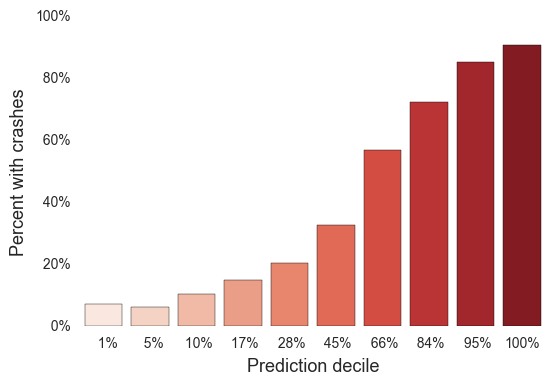

In [87]:
#Lift chart
p = sns.barplot(x = 'decile', y = 'crash_binary', 
                data = crash_mean.reset_index(), 
                palette='Reds')
vals = p.get_yticks()
p.set_yticklabels(['{:3.0f}%'.format(i*100) for i in vals])
xvals = [x.get_text().split(',')[-1].strip(']') for x in p.get_xticklabels()]
xvals = ['{:3.0f}%'.format(float(x)*100) for x in xvals]
p.set_xticklabels(xvals)
p.set_axis_bgcolor('white')
plt.xlabel('Prediction decile', fontsize=13)
plt.ylabel('Percent with crashes', fontsize=13)
plt.show()
plt.cla()
plt.clf()

In [88]:
preds = test.rundict['plusdate']['m_fit'].predict(test.data.test_x[features_plusdate])

In [89]:
from sklearn.metrics import classification_report

In [90]:
print classification_report(test.data.test_y, preds)

             precision    recall  f1-score   support

          0       0.83      0.87      0.85      1996
          1       0.78      0.74      0.76      1314

avg / total       0.81      0.81      0.81      3310

